<a href="https://colab.research.google.com/github/laurabustamante/foraging_tutorial/blob/main/foraging_tutorial_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foraging theory: models and applications to effort-based decision-making
<br>
Welcome to the tutorial! This tutorial was written by Laura Ana Bustamante from Washington University in St. Louis in April, 2024. Much of the code was adapted from scripts provided to me by Nathaniel Daw, Sean Devine, Kevin Lloyd and Sam Zorowitz, many thanks to them.
<br>
In this tutorial you will learn about how to run simulations to get the optimal policy in a patch foraging environment. Then you will estimate individual differences in willingness to exert cognitive and physical effort by fitting a hierarchical Bayesian MVT model. We will also cover how to utilize hierarchical models to estimate correlations between inter-parameter individual differences. We will use open source Effort Foraging Task data from Bustamante and colleagues (2023).
<br>
See the [paper](https://www.pnas.org/doi/10.1073/pnas.2221510120) and [OSF](https://osf.io/a4r2e/) repository for complete information.

# Setup
Install and load packages, load data, and other required files.

In [ ]:
install.packages("R.utils", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("HDInterval", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("lme4", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
library(cmdstanr)
install_cmdstan()
check_cmdstan_toolchain()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘abind’, ‘tensorA’, ‘distributional’, ‘matrixStats’, ‘checkmate’, ‘posterior’


This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

The C++ toolchain required for CmdStan is setup properly!

* Latest CmdStan release is v2.34.1

* Installing CmdStan v2.34.1 in /root/.cmdstan/cmdstan-2.34.1

* Downloading cmdstan-2.34.1.tar.gz from GitHub...

* Download

cp bin/linux-stanc bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.1.1/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.1.1/src/nvector/serial/nvector_serial.c -o stan/lib/stan_math/lib/sundials_6.1.1/src/nvector/serial/nvector_serial.o
chmod +x bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.1.1/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.1.1/src/sundials/sundials_math.c -o stan/lib/stan_math/lib/sundials_6.1.1/src/sundials/sundials_math.o
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1

* Finished installing CmdStan to /root/.cmdstan/cmdstan-2.34.1


CmdStan path set to: /root/.cmdstan/cmdstan-2.34.1

The C++ toolchain required for CmdStan is setup properly!



In [ ]:
library(cmdstanr)
library(lme4)
library(R.utils)
library(magrittr)
library(tidyr)
library(data.table)
library(dplyr)
library(ggplot2)

In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/choiceData_experiment_1.csv.zip"
download.file(urlfile, destfile = "choiceData_experiment_1.csv.zip")
unzip("choiceData_experiment_1.csv.zip")
choiceData_experiment_1 <- readr::read_csv("choiceData_experiment_1.csv")
head(choiceData_experiment_1)

Rows: 351028 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): trial_type, last_commit, first_travel_task, key_press, decision, t...
dbl (32): trial_index, rt, order_num, round, round_duration, travel_duration...
lgl  (1): is_missed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trial_type,trial_index,last_commit,first_travel_task,rt,key_press,decision,order_num,round,travel_task,⋯,second_last_reward,expectedReward,expectedReward_log,travelTask,n_harvest_periods,overall_round,MSIT_trial_type,isMatching,isSmall,subject_id
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
foraging,178,25b0467,button-pressing,347.3,downarrow,stay,8,1,bp,⋯,5.421609,2.385508,0.8694121,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,178,25b0467,button-pressing,329.1,downarrow,stay,8,1,bp,⋯,0.000000,12.162508,2.4983581,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,178,25b0467,button-pressing,544.2,rightarrow,exit,8,1,bp,⋯,13.821032,11.557546,2.4473385,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,378.9,downarrow,stay,8,1,bp,⋯,12.446117,5.476291,1.7004281,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,295.9,downarrow,stay,8,1,bp,⋯,0.000000,12.083010,2.4918003,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,308.4,downarrow,stay,8,1,bp,⋯,13.730693,11.127353,2.4094063,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50


# Simulating patch foraging task to find the best policy

In [ ]:
# Define the optimal_threshold function
optimal_threshold <- function(d, h, mu, sigma, a, b, time) {

  # Initialize variables
  thresh_old <- 4
  tol <- 1e-3
  max_iter <- 200
  diff <- 1e3
  iter_opt <- 0

  # Iterate until convergence or maximum iterations reached
  while (diff > tol && iter_opt < max_iter) {
    iter_opt <- iter_opt + 1
    # Call evaluate_threshold function to get results
    results <- evaluate_threshold(thresh_old, max_iter, d, h, mu, sigma, a, b, time)
    # Update threshold based on average reward rate
    thresh_new <- results$rho_mean * h
    diff <- abs(thresh_new - thresh_old)
    thresh_old <- thresh_new
    # Display iteration information
    cat("iteration", iter_opt, "...")
    cat("... threshold value =", thresh_old, "...")
    cat("... average rho =", results$rho_mean, "\n")
  }

  # Return results as a list
  list(thresh = thresh_new,
       rho = results$rho_mean,
       n_harvests_mean = results$n_harvest_mean,
       n_harvests_sd = results$n_harvest_sd,
       n_exits_mean = results$n_exit_mean,
       n_exits_sd = results$n_exit_sd)
}

# Define the evaluate_threshold function
evaluate_threshold <- function(thresh, iter_eval, d, h, mu, sigma, a, b, time) {

  # Initialize variables
  r_max <- mu + 5
  E_kappa <- a / (a + b)
  exit_harvest_counter <- c()
  rho <- numeric(iter_eval)
  num_exit <- numeric(iter_eval)

  # Iterate for the specified number of evaluations
  for (i in 1:iter_eval) {
    t_counter <- 0
    r_counter <- 0
    harvest_counter <- 0
    exit_harvest_counter_i <- c()

    # Simulate foraging process
    while ((t_counter + h) <= time) {
      if (harvest_counter == 0) {
        # Get initial reward from a normal distribution
        r <- rnorm(1, mean = mu, sd = sigma)
        if (r > r_max) {
          r <- r_max
        }
        t_counter <- t_counter + h
        r_counter <- r_counter + r
        harvest_counter <- harvest_counter + 1
      } else {
        # Calculate expected reward based on decay rate
        Er <- E_kappa * r
        if (Er < thresh) {
          # If expected reward is below threshold, exit
          t_counter <- t_counter + d
          exit_harvest_counter <- c(exit_harvest_counter, harvest_counter)
          exit_harvest_counter_i <- c(exit_harvest_counter_i, harvest_counter)
          harvest_counter <- 0
        } else {
          # If expected reward is above threshold, continue harvesting
          kappa <- rbeta(1, shape1 = a, shape2 = b)
          r <- kappa * r
          r_counter <- r_counter + r
          t_counter <- t_counter + h
          harvest_counter <- harvest_counter + 1
        }
      }
    }
    # Calculate average reward rate and number of exits
    rho[i] <- r_counter / time
    num_exit[i] <- length(exit_harvest_counter_i)
  }

  # Return results as a list
  list(rho_mean = mean(rho),
       n_harvest_mean = mean(exit_harvest_counter),
       n_harvest_sd = sd(exit_harvest_counter),
       n_exit_mean = mean(num_exit),
       n_exit_sd = sd(num_exit))
}

Now we are going to find the best threshold for the environment use in Experiment 1 of Bustamante et al. 2023.

In [ ]:
# call the optimal_threshold function with inputs: (d, h, mu, sigma, a, b, time)
# d = travel time, h = harvest time; start reward, normal distribution: mu, sigma; decay, beta distribution: a, b, time = total orchard time
result <- optimal_threshold(8.33, 2, 15, 1, 14.90873, 2.033008, 480)

# Display the results
print(paste("best exit threshold:",
            round(result$thresh,5)))
print(paste("reward rate achieved:",
            round(result$rho,5)))
print(paste("mean number of harvests before exit:",
            round(result$n_harvests_mean,5)))
print(paste("sd number of harvests before exit:",
            round(result$n_harvests_sd,5)))
print(paste("mean number of exits within simulation time:",
            round(result$n_exits_mean,5)))
print(paste("sd number of exits within simulation time:",
            round(result$n_exits_sd,5)))

iteration 1 ...... threshold value = 6.420907 ...... average rho = 3.210454 
iteration 2 ...... threshold value = 6.794896 ...... average rho = 3.397448 
iteration 3 ...... threshold value = 6.80303 ...... average rho = 3.401515 
iteration 4 ...... threshold value = 6.769229 ...... average rho = 3.384614 
iteration 5 ...... threshold value = 6.780238 ...... average rho = 3.390119 
iteration 6 ...... threshold value = 6.779861 ...... average rho = 3.38993 
[1] "best exit threshold: 6.77986"
[1] "reward rate achieved: 3.38993"
[1] "mean number of harvests before exit: 6.76228"
[1] "sd number of harvests before exit: 1.63756"
[1] "mean number of exits within simulation time: 21.79"
[1] "sd number of exits within simulation time: 0.71305"


# Question 1:
Predict how the exit threshold would change if you increase the average starting reward from 15 to 20 apples? Write code below to find out:

In [ ]:
# Question 1, find the best exit threshold when the starting reward (mu) is set to 20 apples

# Question 2:
Which parameters of the environment could you change to decrease the exit threshold? Confirm your predictions with code.


In [ ]:
# Question 2, starting from the environment used in Experiment 1
# reference:
# result <- optimal_threshold(8.33, 2, 15, 1, 14.90873, 2.033008, 480)
# make as many changes as you can think of to decrease the best exit threshold

# Empirical patch foraging behavior in humans
Do human participants apply the optimal threshold? We will look at behavior in Experiment 1 from the low effort conditions (cognitive and physical)

## Individual differences in overall threshold

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


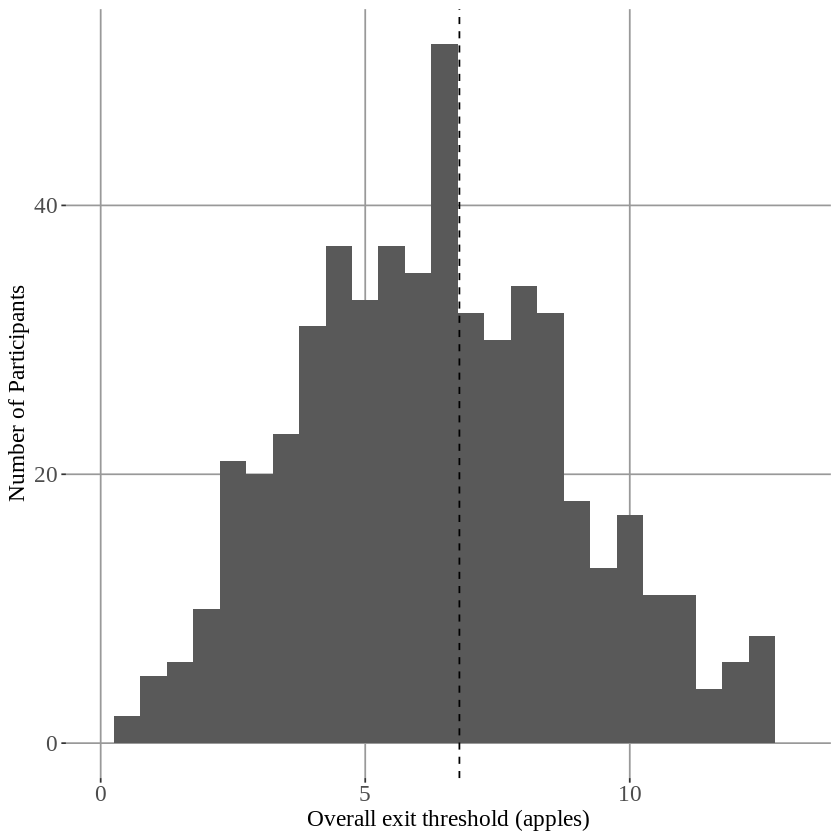

In [ ]:
### Figure S2: Individual differences in overall threshold.
lmer_threshold_subj_experiment_1 <- lmer(
  'expectedReward ~ 1 + (1 | subject_id)',
  data = choiceData_experiment_1 %>%
    filter(decision == "exit",
    effort_level == "low"))
exit_threshold_subj_experiment_1 <- ranef(lmer_threshold_subj_experiment_1)$subject_id %>%
  mutate(subject_id = row.names(.)) %>%
  rename(threshold_subj = "(Intercept)") %>%
  mutate(Threshold = threshold_subj + fixef(lmer_threshold_subj_experiment_1))
threshold_subj_max <- max(max(exit_threshold_subj_experiment_1$Threshold))
p_threshold_subj_experiment_1 <- ggplot(data = exit_threshold_subj_experiment_1) +
  geom_histogram(aes(Threshold),
                 binwidth = 0.5) +
  labs(y = "Number of Participants",
       x = "Overall exit threshold (apples)") +
  scale_y_continuous(breaks = scales::breaks_pretty(n = 3)) +
  scale_x_continuous(limits = c(0,
                                threshold_subj_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_vline(aes(xintercept = 6.78),
             linetype = "dashed")
print(p_threshold_subj_experiment_1)

In [ ]:
# Define the evaluate_threshold function
simulate_data <- function(thresh, d, h, mu, sigma, a, b, time) {
  # Initialize variables
  r_max <- mu + 5
  E_kappa <- a / (a + b)
  # track observed choices and rewards
  choices <- c()
  rewards <- c()
  kappas <- c()
  harvest_counters <- c()
  # Iterate for the specified amount of time
  t_counter <- 0
  r_counter <- 0
  harvest_counter <- 0
  # Simulate foraging process
  while ((t_counter + h) <= time) {
    if (harvest_counter == 0) {
      # Get initial reward from a normal distribution
      r <- rnorm(1, mean = mu, sd = sigma)
      if (r > r_max) {
        r <- r_max
      }
      t_counter <- t_counter + h
      r_counter <- r_counter + r
      harvest_counter <- harvest_counter + 1
      choices <- c(choices, "harvest")
      rewards <- c(rewards, r)
      kappas <- c(kappas, NA)
      harvest_counters <- c(harvest_counters, harvest_counter)
    } else {
      # Calculate expected reward based on decay rate
      Er <- E_kappa * r
      if (Er < thresh) {
        # If expected reward is below threshold, exit
        t_counter <- t_counter + d
        harvest_counter <- 0
        choices <- c(choices, "exit")
        rewards <- c(rewards, 0)
        kappas <- c(kappas, NA)
      } else {
        # If expected reward is above threshold, continue harvesting
        kappa <- rbeta(1, shape1 = a, shape2 = b)
        r <- kappa * r
        r_counter <- r_counter + r
        t_counter <- t_counter + h
        harvest_counter <- harvest_counter + 1
        kappas <- c(kappas, kappa)
        choices <- c(choices, "harvest")
        rewards <- c(rewards, r)
      }
      harvest_counters <- c(harvest_counters, harvest_counter)
    }
  }
  # Calculate average reward rate and number of exits
  data.frame(
    decision = choices,
    reward = rewards,
    travel_duration = d,
    choice_duration = h,
    start_reward_mean = mu,
    start_reward_sd = sigma,
    depletion = kappas,
    depletion_rate_mean = E_kappa,
    depletion_rate_alpha = a,
    depletion_rate_beta = b,
    round_duration = time,
    simulation_threshold = thresh,
    harvest_counter = harvest_counters
    );
}

choiceData_experiment_1_simulated <- c()
for (s in 1:dim(exit_threshold_subj_experiment_1)[1]){
  simulated_participant <- simulate_data(
    exit_threshold_subj_experiment_1$Threshold[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward))
  choiceData_experiment_1_simulated <- bind_rows(choiceData_experiment_1_simulated,
                                      simulated_participant)
}
head(choiceData_experiment_1_simulated,25)


,decision,reward,travel_duration,choice_duration,start_reward_mean,start_reward_sd,depletion,depletion_rate_mean,depletion_rate_alpha,depletion_rate_beta,round_duration,simulation_threshold,harvest_counter,subject_id,last_reward,second_last_reward,expectedReward
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,harvest,16.515964,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,1,08aiu2bm6t15qij5826jxz50,NA,NA,NA
2,harvest,13.551194,8.33,2,15,1,0.8204906,0.88,14.90873,2.033008,480,8.157199,2,08aiu2bm6t15qij5826jxz50,16.515964,NA,NA
3,harvest,11.064300,8.33,2,15,1,0.8164815,0.88,14.90873,2.033008,480,8.157199,3,08aiu2bm6t15qij5826jxz50,13.551194,16.515964,13.229550
4,harvest,10.326704,8.33,2,15,1,0.9333355,0.88,14.90873,2.033008,480,8.157199,4,08aiu2bm6t15qij5826jxz50,11.064300,13.551194,10.830818
5,harvest,10.001989,8.33,2,15,1,0.9685558,0.88,14.90873,2.033008,480,8.157199,5,08aiu2bm6t15qij5826jxz50,10.326704,11.064300,9.412042
6,harvest,9.203047,8.33,2,15,1,0.9201217,0.88,14.90873,2.033008,480,8.157199,6,08aiu2bm6t15qij5826jxz50,10.001989,10.326704,8.944625
7,exit,0.000000,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,0,08aiu2bm6t15qij5826jxz50,9.203047,10.001989,8.450216
8,harvest,15.924158,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,1,08aiu2bm6t15qij5826jxz50,0.000000,9.203047,0.000000
9,harvest,13.995135,8.33,2,15,1,0.8788618,0.88,14.90873,2.033008,480,8.157199,2,08aiu2bm6t15qij5826jxz50,15.924158,0.000000,7.006630


Linear mixed model fit by REML ['lmerMod']
Formula: expectedReward ~ 1 + (1 | subject_id)
   Data: choiceData_experiment_1_simulated %>% filter(decision == "exit")

REML criterion at convergence: 33142.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4644 -0.2748 -0.0236  0.3029  5.3955 

Random effects:
 Groups     Name        Variance Std.Dev.
 subject_id (Intercept) 6.2876   2.5075  
 Residual               0.8283   0.9101  
Number of obs: 11485, groups:  subject_id, 537

Fixed effects:
            Estimate Std. Error t value
(Intercept)   6.3941     0.1086   58.89

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


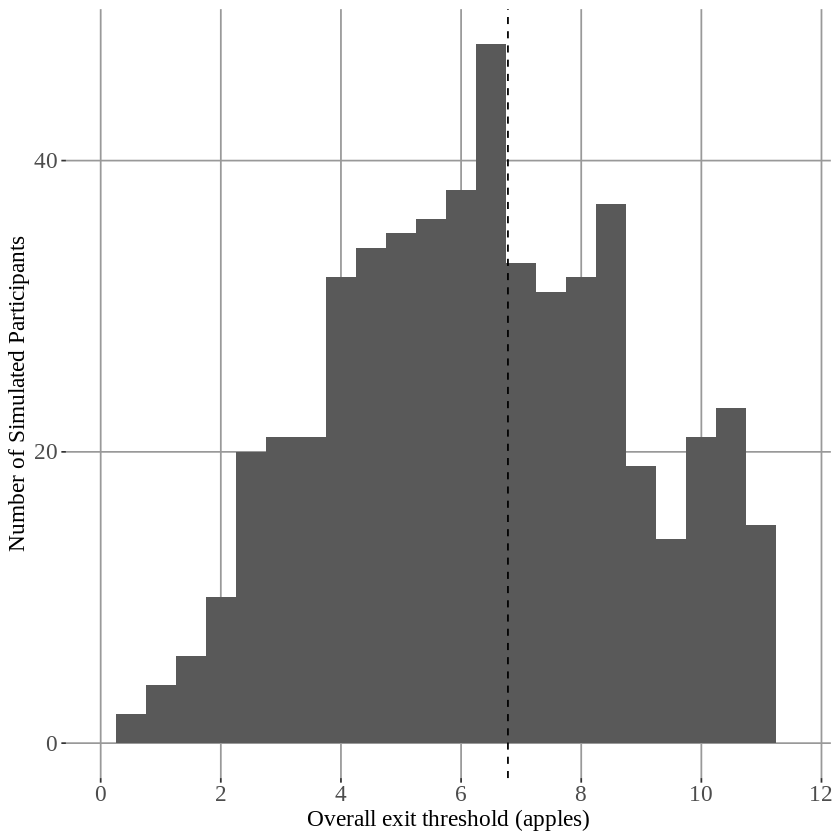

In [ ]:
lmer_threshold_subj_experiment_1_simulated <- lmer(
  'expectedReward ~ 1 + (1 | subject_id)',
  data = choiceData_experiment_1_simulated %>%
    filter(decision == "exit"))
summary(lmer_threshold_subj_experiment_1_simulated)

exit_threshold_subj_experiment_1_simulated <- ranef(lmer_threshold_subj_experiment_1_simulated)$subject_id %>%
  mutate(subject_id = row.names(.)) %>%
  rename(threshold_subj = "(Intercept)") %>%
  mutate(Threshold = threshold_subj + fixef(lmer_threshold_subj_experiment_1_simulated))
threshold_subj_max <- max(max(exit_threshold_subj_experiment_1_simulated$Threshold))
p_threshold_subj_experiment_1_simulated <- ggplot(data = exit_threshold_subj_experiment_1_simulated) +
  geom_histogram(aes(Threshold),
                 binwidth = 0.5) +
  labs(y = "Number of Simulated Participants",
       x = "Overall exit threshold (apples)") +
  scale_y_continuous(breaks = scales::breaks_pretty(n = 3)) +
  scale_x_continuous(limits = c(0,
                                threshold_subj_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_vline(aes(xintercept = 6.78),
             linetype = "dashed")
print(p_threshold_subj_experiment_1_simulated)



# Question 3:
What reasons can you come up with for why some individuals have very high exit thresholds? Or very low thresholds? Can you think of any ways to test your account?

,subject_id,Threshold,Threshold_simulated
,<chr>,<dbl>,<dbl>
1,08aiu2bm6t15qij5826jxz50,8.157199,8.203438
2,09j932f828pn7h7bozp9mpnl,5.682763,5.588782
3,0ax9htcbhfi3ncsospqzwjx2,8.781321,8.777901
4,0e6zivqly335lojgb4c6606t,7.287457,7.395163
5,0fawro1pivqnh4lem4ayf4o0,3.457076,3.618469
6,0jru2culdqol34gpc90oigjn,7.270041,7.312110


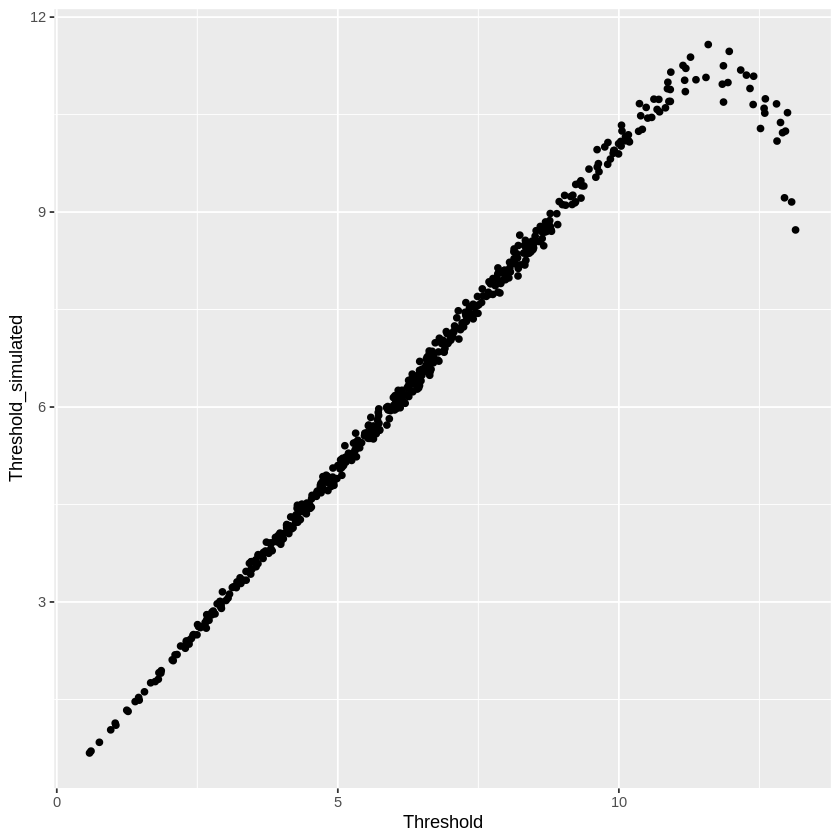

In [ ]:
exit_threshold_compare_real_simulated <- exit_threshold_subj_experiment_1 %>%
  select(subject_id,
Threshold) %>%
  full_join(exit_threshold_subj_experiment_1_simulated %>%
  select(subject_id,
Threshold_simulated = Threshold),
by = "subject_id")
head(exit_threshold_compare_real_simulated)

ggplot(data = exit_threshold_compare_real_simulated,
aes(x = Threshold,
  y = Threshold_simulated)) +
  geom_point()

# Effect of effort on foraging behavior

`summarise()` has grouped output by 'effort_level', 'travel_task'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'effort_level'. You can override using the
`.groups` argument.


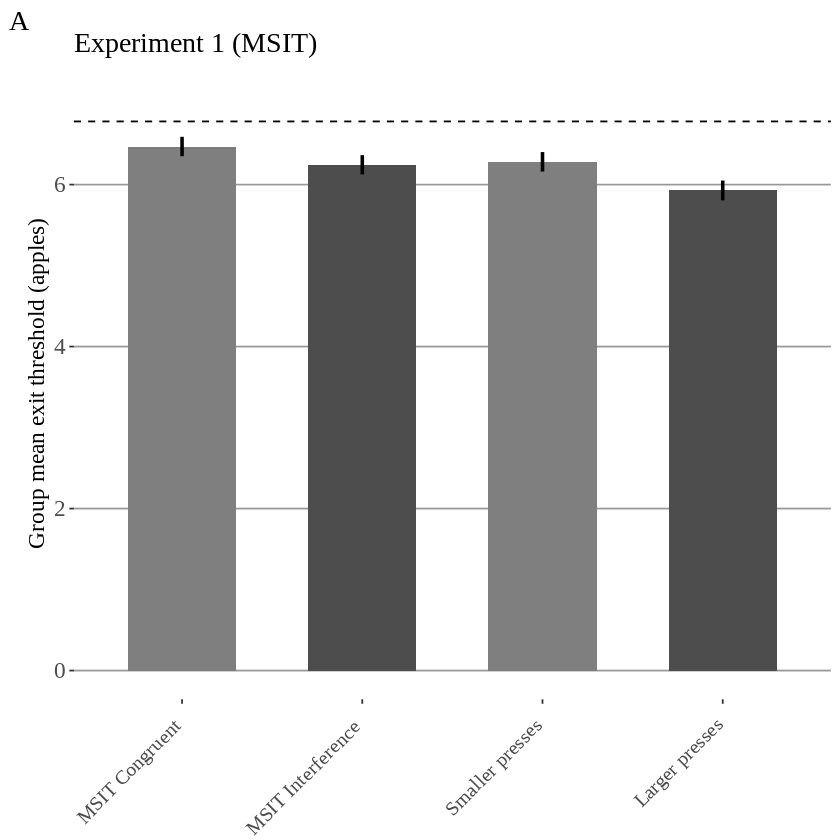

In [ ]:
### Figure S1: Group level exit thresholds by Experiment
threshold_by_effort_type_subj_experiment_1 <- choiceData_experiment_1 %>%
  filter(decision == "exit") %>%
  group_by(effort_level, travel_task, subject_id) %>%
  summarise(Threshold = mean(expectedReward, na.rm = TRUE),
            Threshold_sd = sd(expectedReward, na.rm = TRUE))

threshold_by_effort_type_experiment_1 <- threshold_by_effort_type_subj_experiment_1 %>%
  summarise(threshold = mean(Threshold, na.rm = TRUE),
            nsubj = n(),
            threshold_sem = sd(Threshold, na.rm = TRUE)/sqrt(nsubj)) %>%
  mutate(threshold_sem = ifelse(is.na(threshold_sem), 0, threshold_sem),
         block_str = case_when(effort_level == "low" & travel_task == "msit" ~
                                 "MSIT Congruent",
                               effort_level == "high" & travel_task == "msit" ~
                                 "MSIT Interference",
                               effort_level == "low" & travel_task == "bp" ~
                                 "Smaller presses",
                               effort_level == "high" & travel_task == "bp" ~
                                 "Larger presses"),
         block_str = factor(block_str,
                            levels = c("MSIT Congruent",
                                       "MSIT Interference",
                                       "Smaller presses",
                                       "Larger presses")),
         experiment = "Experiment 1")

threshold_max <- max(threshold_by_effort_type_experiment_1$threshold +
                    threshold_by_effort_type_experiment_1$threshold_sem) + 0.5

p_threshold_experiment_1 <- ggplot(data = threshold_by_effort_type_experiment_1) +
  geom_bar(aes(x = block_str,
               y = threshold,
               fill = effort_level),
           stat = "identity",
           position = position_dodge(),
           width = 0.6,
           size = 2) +
  geom_hline(aes(yintercept = 6.78),
             linetype = "dashed") +
  scale_fill_manual(values=c("grey30",
                             "grey50")) +
      geom_errorbar(aes(x = block_str,
                      ymax = threshold + threshold_sem,
                      ymin = threshold - threshold_sem),
                      width = 0,
                      size = 1,
                      position = position_dodge(width=0.1),
                      color = "black") +
  labs(title = "Experiment 1 (MSIT)",
       y = "Group mean exit threshold (apples)",
       fill = "Effort level",
       tags = "A") +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text.y = element_text(size = 14),
        axis.text.x = element_text(size = 12,
                                   angle = 45,
                                   vjust = 1,
                                   hjust = 1.1),
        axis.title.x = element_blank(),
        legend.position = "none",
        panel.background = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_y_continuous(limits = c(0, threshold_max),
                     breaks = scales::breaks_pretty())
print(p_threshold_experiment_1)

`summarise()` has grouped output by 'subject_id', 'travel_task'. You can
override using the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


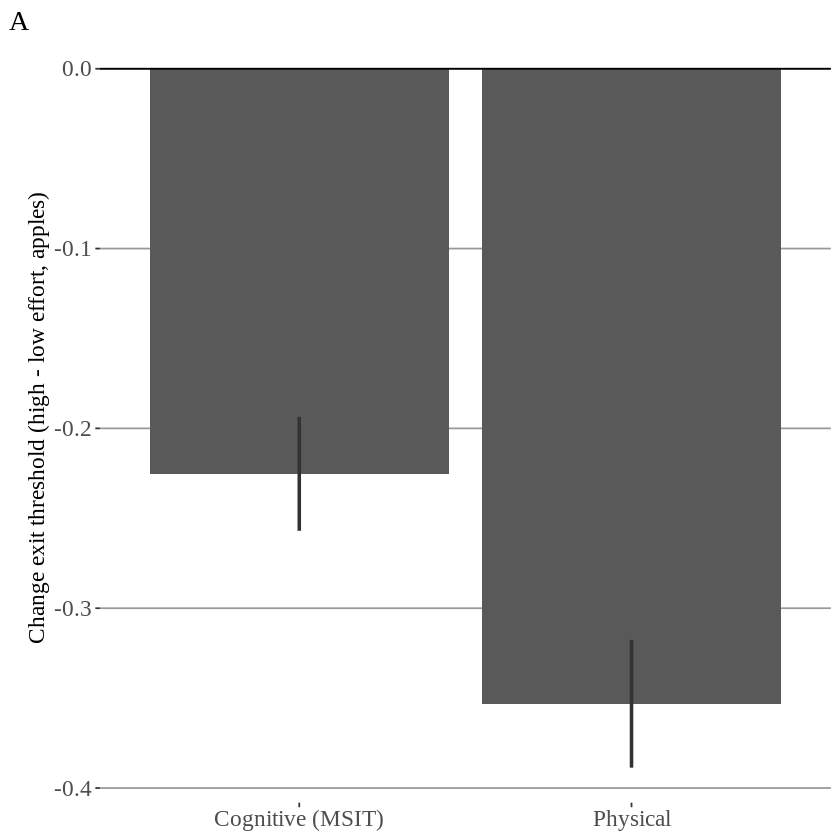

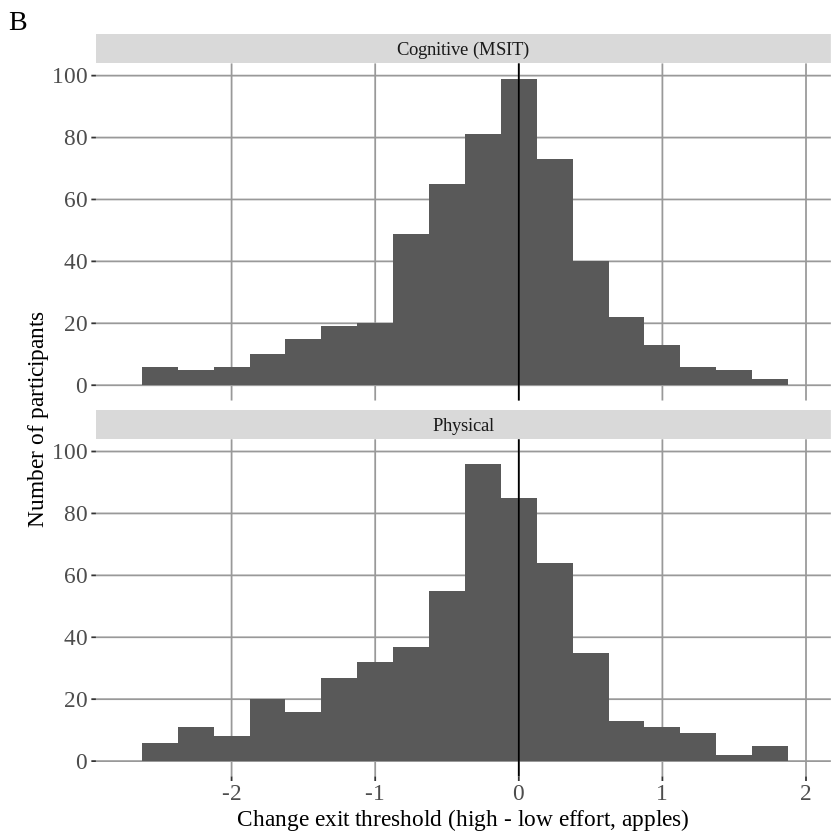

In [ ]:
### Figure 3: Change in exit thresholds by effort condition.
# participant
change_exit_threshold_participant_experiment_1 <- choiceData_experiment_1 %>%
  filter(decision == "exit") %>%
  group_by(subject_id, travel_task, effort_level) %>%
  summarise(exit_threshold = mean(expectedReward, na.rm = TRUE)) %>%
  pivot_wider(names_from = c("travel_task",
                             "effort_level"),
              values_from = c("exit_threshold")) %>%
  mutate(change_exit_msit = msit_high - msit_low,
         change_exit_bp = bp_high - bp_low) %>%
  ungroup() %>%
  select(subject_id,
         change_exit_msit,
         change_exit_bp) %>%
  pivot_longer(-subject_id) %>%
  mutate(effort_type = case_when(name == "change_exit_msit" ~ "Cognitive (MSIT)",
                                 name == "change_exit_bp" ~ "Physical"),
         effort_type = factor(effort_type,
                              levels = c("Cognitive (MSIT)",
                                         "Physical")))
change_exit_threshold_min <- min(change_exit_threshold_participant_experiment_1$value)
change_exit_threshold_max <- max(change_exit_threshold_participant_experiment_1$value)

# group
nsubj_experiment_1 <- length(unique(choiceData_experiment_1$subject_id))
change_exit_threshold_group_experiment_1 <- change_exit_threshold_participant_experiment_1 %>%
  group_by(effort_type) %>%
  summarise(change_threshold_group_mean = mean(value),
            change_threshold_group_sem = sd(value)/sqrt(nsubj_experiment_1))
change_threshold_group_min <- min(change_exit_threshold_group_experiment_1$change_threshold_group_mean -
                         change_exit_threshold_group_experiment_1$change_threshold_group_sem)
# plot
p_change_exit_threshold_group_experiment_1 <- ggplot(
  data = change_exit_threshold_group_experiment_1,
       aes(y = change_threshold_group_mean, x = effort_type)) +
  geom_bar(stat = "identity", position = position_dodge(width=0.9)) +
  labs(y = "Change exit threshold (high - low effort, apples)",
       tag = "A") +
    geom_errorbar(aes(ymax = change_threshold_group_mean + change_threshold_group_sem,
                    ymin= change_threshold_group_mean - change_threshold_group_sem),
                  width = 0,
                  size = 1,
                  position = position_dodge(width=0.9),
                  color = "grey20") +
  geom_hline(yintercept = 0,
             color = "black") +
  scale_y_continuous(limits = c(change_threshold_group_min, 0),
                     breaks = scales::breaks_pretty()) +
  theme(text = element_text(size = 14,
                            family = "Times New Roman"),
        axis.text = element_text(size = 14),
        axis.title.x = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                          linetype = 'solid',
                                colour = "grey60"),
        panel.grid.major.x = element_blank())
print(p_change_exit_threshold_group_experiment_1)

p_change_exit_threshold_participant_experiment_1 <- ggplot(
  data = change_exit_threshold_participant_experiment_1) +
  geom_histogram(aes(value),
                 binwidth = 0.25) +
  facet_wrap(~ effort_type,
             ncol = 1) +
  labs(y = "Number of participants",
       x = "Change exit threshold (high - low effort, apples)",
       tag = "B") +
  scale_y_continuous(breaks = scales::breaks_pretty()) +
  scale_x_continuous(limits = c(change_exit_threshold_min,
                                change_exit_threshold_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "Times New Roman"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                          linetype = 'solid',
                                colour = "grey60")) +
  geom_vline(xintercept = 0)
print(p_change_exit_threshold_participant_experiment_1)

# Question 4:
Now calculate the change in exit threshold from high to low cognitive effort and simulate it. How will can you recover the change in exit threshold?

In [ ]:
# Extract the threshold for high and low effort for each participant,
# simulate the data, and compare the change in exit threshold for the simulated versus empirical data.
lmer_change_threshold_subj_experiment_1 <- lmer(
  'expectedReward ~ 1 + isMatching + (1 + isMatching | subject_id)',
  data = choiceData_experiment_1 %>%
    filter(decision == "exit",
           travelTask == "MSIT"))
change_exit_threshold_subj_experiment_1 <- ranef(lmer_change_threshold_subj_experiment_1)$subject_id %>%
  transmute(subject_id = row.names(.),
         threshold_high_effort = `(Intercept)`+fixef(lmer_change_threshold_subj_experiment_1)[1],
         threshold_change = isMatching+fixef(lmer_change_threshold_subj_experiment_1)[2],
         threshold_low_effort = threshold_high_effort+threshold_change)
head(change_exit_threshold_subj_experiment_1)

choiceData_experiment_1_change_threshold_simulated <- c()
for (s in 1:dim(change_exit_threshold_subj_experiment_1)[1]){
  simulated_low_effort_participant <- simulate_data(
    change_exit_threshold_subj_experiment_1$threshold_low_effort[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = change_exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward),
            isMatching = 1)
  simulated_high_effort_participant <- simulate_data(
    change_exit_threshold_subj_experiment_1$threshold_high_effort[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = change_exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward),
            isMatching = 0)
  choiceData_experiment_1_change_threshold_simulated <- bind_rows(choiceData_experiment_1_change_threshold_simulated,
                                      simulated_low_effort_participant) %>%
                                        bind_rows(., simulated_high_effort_participant)
}
head(choiceData_experiment_1_change_threshold_simulated,25)

,subject_id,threshold_high_effort,threshold_change,threshold_low_effort
,<chr>,<dbl>,<dbl>,<dbl>
08aiu2bm6t15qij5826jxz50,08aiu2bm6t15qij5826jxz50,7.525899,-0.43439470,7.091504
09j932f828pn7h7bozp9mpnl,09j932f828pn7h7bozp9mpnl,4.384694,0.81643559,5.201129
0ax9htcbhfi3ncsospqzwjx2,0ax9htcbhfi3ncsospqzwjx2,8.401473,0.27353324,8.675006
0e6zivqly335lojgb4c6606t,0e6zivqly335lojgb4c6606t,7.414251,-0.13104155,7.283210
0fawro1pivqnh4lem4ayf4o0,0fawro1pivqnh4lem4ayf4o0,2.747724,0.89729533,3.645020
0jru2culdqol34gpc90oigjn,0jru2culdqol34gpc90oigjn,7.499753,-0.04907372,7.450679


,decision,reward,travel_duration,choice_duration,start_reward_mean,start_reward_sd,depletion,depletion_rate_mean,depletion_rate_alpha,depletion_rate_beta,round_duration,simulation_threshold,harvest_counter,subject_id,last_reward,second_last_reward,expectedReward,isMatching
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,harvest,16.049344,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,7.091504,1,08aiu2bm6t15qij5826jxz50,NA,NA,NA,1
2,harvest,14.212446,8.33,2,15,1,0.8855469,0.88,14.90873,2.033008,480,7.091504,2,08aiu2bm6t15qij5826jxz50,16.049344,NA,NA,1
3,harvest,10.414216,8.33,2,15,1,0.7327532,0.88,14.90873,2.033008,480,7.091504,3,08aiu2bm6t15qij5826jxz50,14.212446,16.049344,13.315188,1
4,harvest,9.141005,8.33,2,15,1,0.8777430,0.88,14.90873,2.033008,480,7.091504,4,08aiu2bm6t15qij5826jxz50,10.414216,14.212446,10.835732,1
5,harvest,6.325668,8.33,2,15,1,0.6920101,0.88,14.90873,2.033008,480,7.091504,5,08aiu2bm6t15qij5826jxz50,9.141005,10.414216,8.604298,1
6,exit,0.000000,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,7.091504,0,08aiu2bm6t15qij5826jxz50,6.325668,9.141005,6.805336,1
7,harvest,15.002422,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,7.091504,1,08aiu2bm6t15qij5826jxz50,0.000000,6.325668,0.000000,1
8,harvest,12.706165,8.33,2,15,1,0.8469409,0.88,14.90873,2.033008,480,7.091504,2,08aiu2bm6t15qij5826jxz50,15.002422,0.000000,6.601066,1
9,harvest,12.318803,8.33,2,15,1,0.9695139,0.88,14.90873,2.033008,480,7.091504,3,08aiu2bm6t15qij5826jxz50,12.706165,15.002422,12.191779,1


,subject_id,threshold_high_effort,threshold_change,threshold_low_effort
,<chr>,<dbl>,<dbl>,<dbl>
08aiu2bm6t15qij5826jxz50,08aiu2bm6t15qij5826jxz50,7.502265,-0.23287918,7.269385
09j932f828pn7h7bozp9mpnl,09j932f828pn7h7bozp9mpnl,4.376704,0.74908418,5.125788
0ax9htcbhfi3ncsospqzwjx2,0ax9htcbhfi3ncsospqzwjx2,8.476763,0.24693673,8.723700
0e6zivqly335lojgb4c6606t,0e6zivqly335lojgb4c6606t,7.396718,0.05402327,7.450741
0fawro1pivqnh4lem4ayf4o0,0fawro1pivqnh4lem4ayf4o0,2.891943,0.66098286,3.552926
0jru2culdqol34gpc90oigjn,0jru2culdqol34gpc90oigjn,7.453112,0.22128756,7.674399


,subject_id,threshold_high_effort,threshold_change,threshold_high_effort_simulated,threshold_change_simulated
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,08aiu2bm6t15qij5826jxz50,7.525899,-0.43439470,7.502265,-0.23287918
2,09j932f828pn7h7bozp9mpnl,4.384694,0.81643559,4.376704,0.74908418
3,0ax9htcbhfi3ncsospqzwjx2,8.401473,0.27353324,8.476763,0.24693673
4,0e6zivqly335lojgb4c6606t,7.414251,-0.13104155,7.396718,0.05402327
5,0fawro1pivqnh4lem4ayf4o0,2.747724,0.89729533,2.891943,0.66098286
6,0jru2culdqol34gpc90oigjn,7.499753,-0.04907372,7.453112,0.22128756


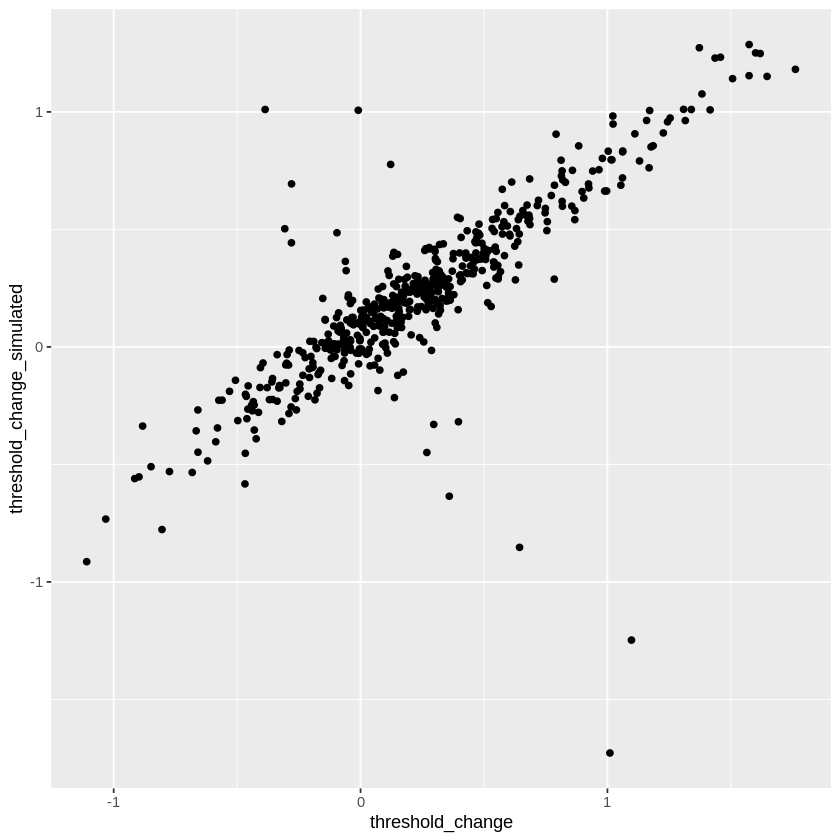

In [ ]:
lmer_change_threshold_subj_experiment_1_simulated <- lmer(
  'expectedReward ~ 1 + isMatching + (1 + isMatching | subject_id)',
  data = choiceData_experiment_1_change_threshold_simulated %>%
    filter(decision == "exit"))
change_exit_threshold_subj_experiment_1_simulated <- ranef(lmer_change_threshold_subj_experiment_1_simulated)$subject_id %>%
  transmute(subject_id = row.names(.),
         threshold_high_effort = `(Intercept)`+fixef(lmer_change_threshold_subj_experiment_1_simulated)[1],
         threshold_change = isMatching+fixef(lmer_change_threshold_subj_experiment_1_simulated)[2],
         threshold_low_effort = threshold_high_effort+threshold_change)
head(change_exit_threshold_subj_experiment_1_simulated)

change_exit_threshold_compare_real_simulated <- change_exit_threshold_subj_experiment_1 %>%
  select(subject_id,
         threshold_high_effort,
         threshold_change) %>%
  full_join(change_exit_threshold_subj_experiment_1_simulated %>%
            select(subject_id,
            threshold_high_effort_simulated = threshold_high_effort,
            threshold_change_simulated = threshold_change),
by = "subject_id")
head(change_exit_threshold_compare_real_simulated)

ggplot(data = change_exit_threshold_compare_real_simulated,
aes(x = threshold_change,
  y = threshold_change_simulated)) +
  geom_point()

# Question 5:
We predicted participants would have a lower exit threshold in the high versus low effort condition. Here we can see that some participants showed a higher exit threshold in the high relative to low effort condition. What hypotheses can you come up with for why participants did this? Can you think of an analysis you can do in this study to test your account? If not, is there an experiment you could design to test your hypothesis?

# Hierarchal Bayesian MVT model

First we will load data formatted for the model, the OSF repository includes code to create this data.

In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/foraging_mvt_stan_data_experiment_1.csv.zip"
download.file(urlfile, destfile = "foraging_mvt_stan_data_experiment_1.zip")
unzip("foraging_mvt_stan_data_experiment_1.zip")
data <- readr::read_csv("foraging_mvt_stan_data_experiment_1.csv")
head(data)
# stan requires a list as input
foraging_experiment_1_standata <- list(NS = unique(data$NS),
                               K = dim(data)[1],
                               choose_stay = data$choose_stay,
                               which_S = data$which_S,
                               total_reward = data$total_reward,
                               total_harvest_periods = data$total_harvest_periods,
                               number_trees = data$number_trees,
                               expected_reward = data$expected_reward,
                               is_Matching = data$is_Matching,
                               is_Mismatching = data$is_Mismatching,
                               is_small = data$is_small,
                               is_large = data$is_large)

Rows: 344217 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): subject_id
dbl (13): NS, NT, MT, which_S, choose_stay, total_reward, total_harvest_peri...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


NS,NT,MT,which_S,choose_stay,total_reward,total_harvest_periods,number_trees,expected_reward,is_Matching,is_Mismatching,is_small,is_large,subject_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
537,607,848,1,1,1383.913,240,24,2.385508,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,12.162508,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,0,1383.913,240,24,11.557546,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,5.476291,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,12.083010,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,11.127353,0,0,1,0,08aiu2bm6t15qij5826jxz50


In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/fit_mvt_stan_model_experiment_1.stan"
download.file(urlfile, destfile = "/content/fit_mvt_stan_model_experiment_1.stan")
mod <- cmdstan_model("/content/fit_mvt_stan_model_experiment_1.stan")
# inspect model code
mod$print()

//aria:compile=0
data {
  int NS; // number of particiants
  int K; // length of all trials for all participants 
  array[K] int choose_stay; // whether participant exits the patch (0) or not (1)
  array[K] int<lower=1, upper=NS> which_S;
  vector[K] total_reward; // total rewards per block type
  vector[K] total_harvest_periods; // time spent per block type
  vector[K] number_trees; // how many trees visited per block type
  vector[K] expected_reward; // reward expected on a trial 
  vector[K] is_Matching; // 1 = congruent trial block, 0 = not 
  vector[K] is_Mismatching; // 1 = interference trial block, 0 = not 
  vector[K] is_small; // 1 = physical low efffort block, 0 = not 
  vector[K] is_large; // 1 = physical high efffort block, 0 = not 
} 

transformed data {
  // fixed effects prior ~ N(X_mu_prior, X_s_prior)
  // [1] = log inv_temp
  // [2] = cost_congruent
  // [3] = cost_interference
  // [4] = cost_small
  // [5] = cost_large
  vector[5] gam_mu_prior = [0, 0, 0, 0, 0]';   

## Run the model
Note the sampling can take hours, so this code will show you how to run the model, but we will proceed with a pre-fitted model

In [ ]:
# note the sampling can take hours
fit_experiment_1 <- mod$sample(
  data = foraging_experiment_1_standata,
  chains = 4,
  parallel_chains = 4,
  refresh = 150,
  iter_warmup = 500,
  iter_sampling = 1000,
  thin = 1
)

fit_experiment_1$summary()
cost_travel_experiment_1_fit_full <- fit_experiment_1$draws(format = "df")
# save the draws and also the model fit object
# saveRDS(fit_experiment_1, "fit_experiment_1.rds")
# write_csv(cost_travel_experiment_1_fit_full, "cost_travel_experiment_1_fit_full.csv")

Running MCMC with 4 parallel chains...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpj9o3ik/model-946472318a.stan', line 66, column 2 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpj9o3ik/model-946472318a.stan', line 66, column 2 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but 

## Visualize pre-fitted model

In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/cmdstan_samples_allsubs_experiment_1.tsv.gz"
download.file(urlfile, destfile = "/content/cmdstan_samples_allsubs_experiment_1.tsv.gz")
# load pre-fitted model
cost_travel_stan_fit_experiment_1 <- data.table::fread("/content/cmdstan_samples_allsubs_experiment_1.tsv.gz") %>%
  mutate(rownum = row_number(),
         Chain = case_when(rownum > 0 & rownum <= 1000 ~ 1,
                           rownum > 1000 & rownum <= 2000 ~ 2,
                           rownum > 2000 & rownum <= 3000 ~ 3,
                           rownum > 3000 & rownum <= 4000 ~ 4))
cost_travel_fit_vars <- c("inv_temp",
                          "cost_matching",
                          "cost_mismatching",
                          "cost_small",
                          "cost_large")
cost_travel_fit_vars_titles <- c("Inverse Tempurature",
                                "Cognitive Low Effort Travel Cost",
                                "Cognitive Effort Cost",
                                "Physical Low Effort Travel Cost",
                                "Physical Effort Cost")

## Group level posterior distributions

In [ ]:
### Table S1: Group level posterior distributions.
cost_travel_stan_fit_group_experiment_1 <- cost_travel_stan_fit_experiment_1 %>%
    select(contains("beta_ms[")) %>%
    pivot_longer(everything(),
                 names_to = "params",
                 values_to = "params_val") %>%
    mutate(param_name = case_when(params == "beta_ms[1]" ~ cost_travel_fit_vars_titles[1],
                                  params == "beta_ms[2]" ~ cost_travel_fit_vars_titles[2],
                                  params == "beta_ms[3]" ~ cost_travel_fit_vars_titles[3],
                                  params == "beta_ms[4]" ~ cost_travel_fit_vars_titles[4],
                                  params == "beta_ms[5]" ~ cost_travel_fit_vars_titles[5]))
table_S1 <- cost_travel_stan_fit_group_experiment_1 %>%
  ungroup() %>%
  group_by(param_name) %>%
  summarise(mean = mean(params_val),
            lower = HDInterval::hdi(params_val, credMass = 0.95)[1],
            upper = HDInterval::hdi(params_val, credMass = 0.95)[2]) %T>%
  print()

# A tibble: 5 × 4
  param_name                         mean  lower   upper
  <chr>                             <dbl>  <dbl>   <dbl>
1 Cognitive Effort Cost             7.55   5.47    9.62 
2 Cognitive Low Effort Travel Cost 94.6   90.7    98.7  
3 Inverse Tempurature               0.260  0.239   0.283
4 Physical Effort Cost             13.5   10.9    15.9  
5 Physical Low Effort Travel Cost  99.8   95.4   104.   


## Individual differences in effort costs

Rows: 2685 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): param_name, param_name_str, subject_id
dbl (4): mean, lower, upper, HDIInterval_width

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


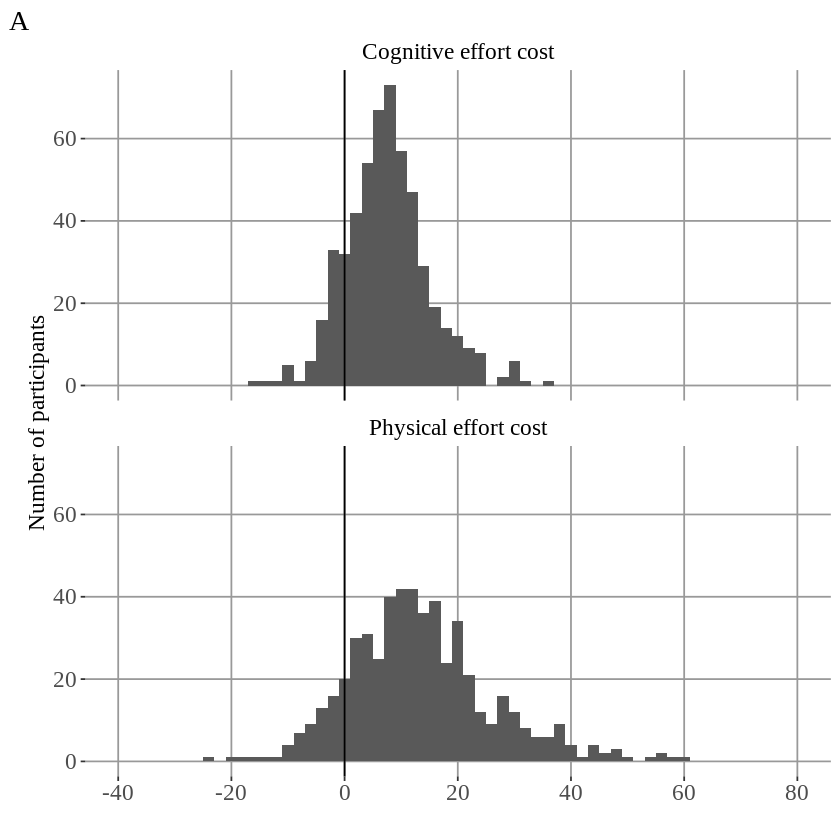

In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/cost_travel_participant_experiment_1.csv.zip"
download.file(urlfile, destfile = "/content/cost_travel_participant_experiment_1.csv.zip")
unzip("/content/cost_travel_participant_experiment_1.csv.zip")
cost_travel_participant_experiment_1 <- readr::read_csv("cost_travel_participant_experiment_1.csv") %>%
   mutate(param_name_str = case_when(param_name == "cost_large" ~ "Physical effort cost",
                                    param_name == "cost_small" ~ "Physical low effort cost",
                                    param_name == "cost_matching" ~ "Cognitive low effort cost",
                                    param_name == "cost_mismatching" ~ "Cognitive effort cost",
                                    param_name == "inv_temp" ~ "Inverse tempurature"))
# histogram of individual differences in effort cost
cost_min <- min(filter(cost_travel_participant_experiment_1,
                      param_name == "cost_mismatching" |
                      param_name == "cost_large")$lower)
cost_max <- max(filter(cost_travel_participant_experiment_1,
                      param_name == "cost_mismatching" |
                      param_name == "cost_large")$upper)
p_cost_travel_histogram_experiment_1 <- ggplot(data = cost_travel_participant_experiment_1 %>%
         filter(param_name == "cost_mismatching" |
                param_name == "cost_large")) +
  geom_histogram(aes(mean),
                 binwidth = 2) +
  facet_wrap(~ param_name_str, ncol=1) +
  labs(y = "Number of participants",
       x = " ",
       tag = "A") +
  geom_vline(aes(xintercept = 0),
             color = "black") +
  theme(text = element_text(size = 14,
                            family = "serif"),
        axis.text = element_text(size = 14),
        strip.background = element_rect(fill="white"),
        strip.text = element_text(size = 14,
                                  colour="black"),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_y_continuous(breaks=scales::breaks_pretty()) +
  scale_x_continuous(breaks=scales::breaks_pretty(),
                     limits = c(cost_min,
                                cost_max))
print(p_cost_travel_histogram_experiment_1)

## Correlation between individual differences in cognitive and physical effort costs

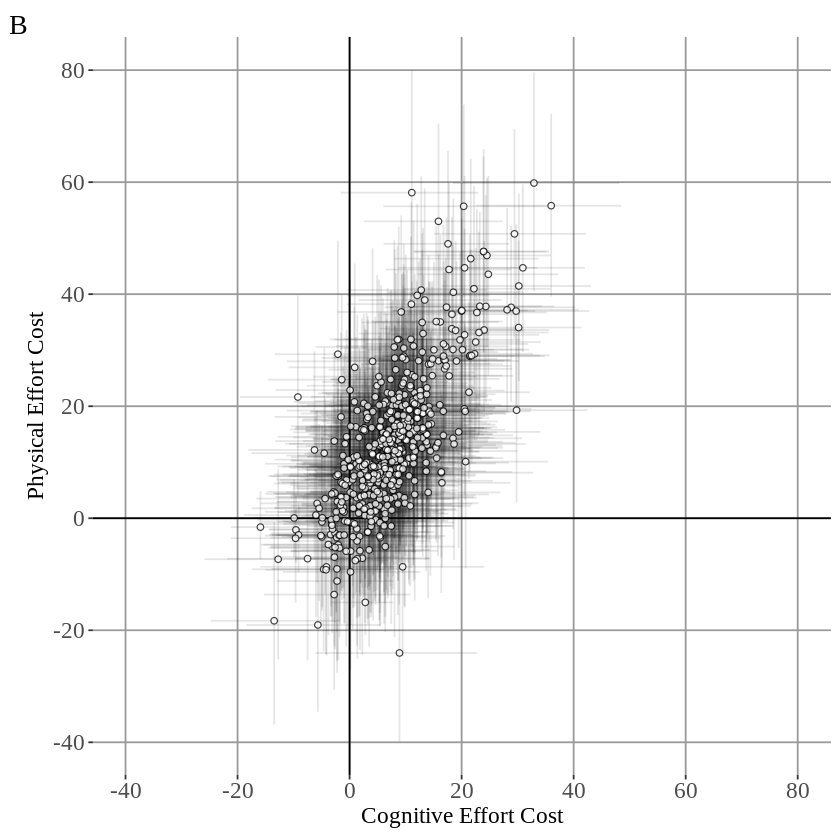

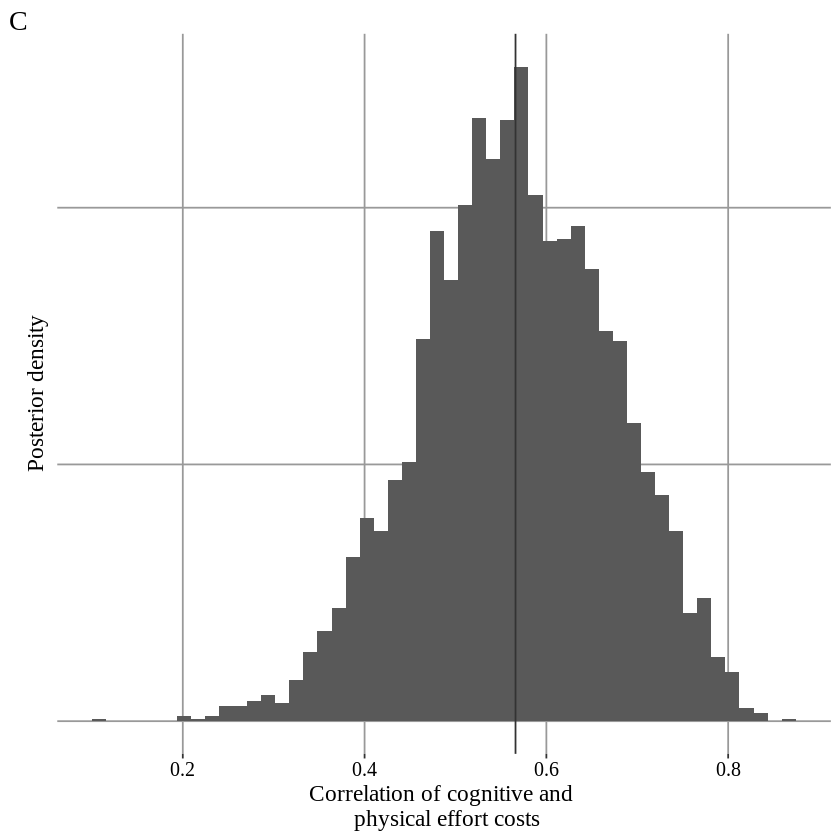

In [ ]:
### Figure 4: Correlation between individual differences in cognitive and physical effort costs.
# scatter plot cognitive versus physical effort cost with HDI intervals
cost_travel_param_participant_experiment_1 <- cost_travel_participant_experiment_1 %>%
         mutate(HDIInterval_width = upper - lower) %>%
         ungroup() %>%
         select(-param_name_str) %>%
         pivot_wider(names_from = param_name,
                     values_from = c(mean, lower, upper, HDIInterval_width))
cost_max <- max(max(cost_travel_param_participant_experiment_1$upper_cost_large),
                max(cost_travel_param_participant_experiment_1$upper_cost_mismatching))
cost_min <- min(min(cost_travel_param_participant_experiment_1$lower_cost_large),
                min(cost_travel_param_participant_experiment_1$lower_cost_mismatching))
p_cost_travel_scatter_experiment_1 <- ggplot(data = cost_travel_param_participant_experiment_1,
       aes(x = mean_cost_mismatching,
           y = mean_cost_large)) +
  labs(x = "Cognitive Effort Cost",
       y = "Physical Effort Cost",
       tag = "B") +
  geom_vline(aes(xintercept = 0),
             color = "black") +
  geom_hline(aes(yintercept = 0),
           color = "black") +
  geom_errorbar(aes(xmin = lower_cost_mismatching,
                    xmax = upper_cost_mismatching),
                alpha = 0.1) +
  geom_errorbar(aes(ymin = lower_cost_large,
                    ymax = upper_cost_large),
                alpha = 0.1) +
  geom_point(color = "black",
             fill = "white",
             alpha = 0.75,
             pch=21) +
  theme(text = element_text(size = 14,
                            family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
    coord_fixed(xlim = c(cost_min, cost_max),
                ylim = c(cost_min, cost_max)) +
  scale_y_continuous(breaks=scales::breaks_pretty()) +
  scale_x_continuous(breaks=scales::breaks_pretty())
print(p_cost_travel_scatter_experiment_1)

p_cog_phys_correlation_posterior_experiment_1 <- ggplot(
  data = cost_travel_stan_fit_experiment_1,
      aes(x = `r[3,5]`)) +
  geom_histogram(bins = 50) +
  geom_vline(aes(xintercept = mean(cost_travel_stan_fit_experiment_1$`r[3,5]`)),
           color = "grey20") +
  labs(y = "Posterior density",
       x = "Correlation of cognitive and \n physical effort costs",
       tag = "C") +
  theme(text = element_text(family = "serif",
                            size = 14),
        axis.text = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(family = "serif",
                            size = 12),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_x_continuous(breaks=scales::pretty_breaks()) +
  scale_fill_manual(values = c("transparent",
                               "grey50",
                               "transparent"),
                    guide = "none")
print(p_cog_phys_correlation_posterior_experiment_1)


# Question 5:
In this experiment participants who avoided cognitive effort more also avoided physical effort more. What reasons can you think of for why that might be? How does it compare to your real life experiences?